In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.metrics import bleu_score
import torchtext.data
from torch.nn.utils.rnn import pad_sequence
import spacy

import math
from copy import deepcopy
import matplotlib.pyplot as plt
import os

import requests
from datasets import load_dataset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
DEVICE="cuda"
torch.manual_seed(1)
np.random.seed(1)

In [3]:
class Attention(nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super(Attention,self).__init__()
        self.nhead = nhead
        self.d_model = d_model
        self.d_k = d_model//nhead
        self.W_q = nn.Linear(self.d_model, self.d_model)
        self.W_k = nn.Linear(self.d_model, self.d_model)
        self.W_v = nn.Linear(self.d_model, self.d_model)
        self.W_o = nn.Linear(self.d_model, self.d_model)
        
    def forward(self, Q, K, V, pad_mask=None, attn_mask=None):
        Q=self.W_q(Q)
        K=self.W_k(K)
        V=self.W_v(V)
        
        Q = Q.reshape(Q.shape[0], Q.shape[1], self.nhead, self.d_k).transpose(0, 2)
        K = K.reshape(K.shape[0], K.shape[1], self.nhead, self.d_k).transpose(0, 2)
        V = V.reshape(V.shape[0], V.shape[1], self.nhead, self.d_k).transpose(0, 2)
        
        X = torch.matmul(Q, K.transpose(2,3)) / math.sqrt(self.d_k)
        if (pad_mask is not None):
            X=X.masked_fill(pad_mask.reshape(1,pad_mask.shape[0],1,pad_mask.shape[1]), -1.0e10)
        
        if (attn_mask is not None):
            X=X.masked_fill(attn_mask.reshape(1,1,attn_mask.shape[0],attn_mask.shape[1]), -1.0e10)
        
        X = torch.softmax(X,dim=3)
        X = torch.matmul(X, V)
        X = X.transpose(0,2)
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2]*X.shape[3])
        X = self.W_o(X)
        return X
    
class Encoder(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super(Encoder, self).__init__()
        self.mha = Attention(d_model, nhead, dropout)
        #self.mha = nn.MultiheadAttention(d_model,nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self, X, src_pad_mask=None):
        sub_X = self.mha(X,X,X,src_pad_mask)
        X=self.norm1(X+self.dropout(sub_X))
        sub_X=self.feed_forward(X)
        X=self.norm2(X+self.dropout(sub_X))
        return X

class Decoder(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super(Decoder, self).__init__()
        self.mha = Attention(d_model, nhead, dropout)
        self.masked_mha = Attention(d_model, nhead, dropout)
        #self.mha = nn.MultiheadAttention(d_model,nhead)
        #self.masked_mha = nn.MultiheadAttention(d_model,nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X, memory, src_pad_mask=None, trg_pad_mask=None):
        sub_X=self.masked_mha(X,X,X, trg_pad_mask, 
                              attn_mask=(1-torch.tril(torch.ones(X.shape[0],X.shape[0]))).bool().to(DEVICE))
        X=self.norm1(X+self.dropout(sub_X))
        sub_X = self.mha(X, memory, memory, src_pad_mask)
        X=self.norm2(X+self.dropout(sub_X))
        sub_X = self.feed_forward(X)
        X=self.norm3(X+self.dropout(sub_X))
        return X

class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=1000):
        super(PositionalEncoding, self).__init__()
        PE=torch.empty((max_len,d_model))
        pos=torch.arange(max_len).reshape((max_len,1))
        wave_len=10000**(torch.arange(0,d_model,step=2)/d_model)
        PE[:,0::2]=torch.sin(pos*wave_len)
        PE[:,1::2]=torch.cos(pos*wave_len)
        self.register_buffer('PE', PE) #to run on gpu
    def forward(self, X):
        return X+self.PE[0:len(X),].reshape((len(X),1,X.shape[2]))


class Transformer(nn.Module):
    def __init__(self,src_vocab_size,trg_vocab_size,
                 n_encoders=6,n_decoders=6,d_model=512,nhead=8,d_ff=2048,dropout= 0.1):
        super(Transformer, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.trg_tok_emb = nn.Embedding(trg_vocab_size, d_model)
        self.encoder = nn.ModuleList([deepcopy(Encoder(
            d_model,nhead,d_ff,dropout
        )) for i in range(n_encoders)])
        self.decoder = nn.ModuleList([deepcopy(Decoder(
            d_model,nhead,d_ff,dropout
        )) for i in range(n_decoders)])
        self.generator = nn.Linear(d_model, trg_vocab_size)
        self.positional_encoding = PositionalEncoding(d_model)

    def forward(self,src,trg):
        memory = self.src_tok_emb(src)
        memory=self.positional_encoding(memory)
        output = self.trg_tok_emb(trg)
        output=self.positional_encoding(output)
        src_pad_mask=(src == PAD_IDX).transpose(0,1)
        trg_pad_mask=(trg == PAD_IDX).transpose(0,1)
        
        
        for encoder in self.encoder:
            memory=encoder(memory,src_pad_mask)
        for decoder in self.decoder:
            output = decoder(output,
                             memory,
                             src_pad_mask,trg_pad_mask)

        return self.generator(output)
    
    def encode(self,src):
        memory = self.src_tok_emb(src)
        memory=self.positional_encoding(memory)
        for encoder in self.encoder:
            memory=encoder(memory)
        return memory

    def decode(self,trg,memory):
        output = self.trg_tok_emb(trg)
        output=self.positional_encoding(output)
        for decoder in self.decoder:
            output = decoder(output,
                             memory)
        return output

In [4]:
#define constants
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3 #special token indices

#get vocabularies and text tokenizers
def get_vocab_text(dat,tokenizer):
    counter = Counter()
    for s in dat:
        counter.update(list(tokenizer(s)))
    vocab = build_vocab_from_iterator([counter], specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    vocab.set_default_index(vocab['<unk>'])
    def text_tok(text):
        str_tokens=tokenizer(text)
        int_tokens=vocab(str_tokens)
        return torch.cat((torch.tensor([BOS_IDX]),torch.tensor(int_tokens),torch.tensor([EOS_IDX])))
    return vocab,text_tok
    
    

class CustomDataset(Dataset):
    def __init__(self, src, trg):
        super().__init__()
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]

def get_dataloader(dat_src,dat_trg,text_tok_src,text_tok_trg,train_split=0.8):
    dat_st=CustomDataset(dat_src,dat_trg)
    train_data, val_data = random_split(dat_st, [train_split, 1-train_split])
    def collate_fn(batch):
        src_batch, trg_batch = [], []
        for src,trg in batch:
            src_batch.append(text_tok_src(src))
            trg_batch.append(text_tok_trg(trg))
        return pad_sequence(src_batch, padding_value=PAD_IDX), pad_sequence(trg_batch, padding_value=PAD_IDX)

    train_dataloader = DataLoader(train_data, batch_size=128, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_data, batch_size=128, collate_fn=collate_fn)
    return train_dataloader, val_dataloader


In [13]:
#downloaded from https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench
dat=pd.read_csv("eng_-french.csv") 
dat_en=dat["English words/sentences"].to_numpy()[0:150000]
dat_fr=dat["French words/sentences"].to_numpy()[0:150000]
print(len(dat_en))

#get tokenizers
spacy_en = get_tokenizer('spacy', language='en_core_web_sm')
spacy_fr = get_tokenizer('spacy', language='fr_core_news_sm')

150000


In [14]:
vocab_en,text_en=get_vocab_text(dat_en,spacy_en)
print(text_en("hello world!"))
vocab_fr,text_fr=get_vocab_text(dat_fr,spacy_fr)

train_dataloader, val_dataloader = get_dataloader(dat_en,dat_fr,text_en,text_fr)

tensor([   2, 1965,  597,  115,    3])


In [15]:
def train(transformer, train_dataloader, val_dataloader,  criterion, optimizer, plt_title, epochs=10):
    start=timer()
    train_loss=np.zeros(epochs)
    val_loss=np.zeros(epochs)
    for epoch in range(epochs):
        #print(f"epoch {epoch}")
        transformer.train()

        for src, trg in train_dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            out = transformer(src, trg[:-1, :])
            out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
            loss = criterion(out, trg[1:, :].flatten())
            optimizer.zero_grad()
            loss.backward()
            train_loss[epoch] += loss.item()
            optimizer.step()
        #print(f"training loss: {train_loss/len(list(train_dataloader))}")
        #print(f"time: {timer()-start}")

        transformer.eval()

        for src, trg in val_dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            out = transformer(src, trg[:-1, :])
            out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
            loss = criterion(out, trg[1:, :].flatten())
            val_loss[epoch] += loss.item()

        #print(f"validation loss: {val_loss/len(list(val_dataloader))}")
        print(f"time: {timer()-start}")
    
    train_loss/=len(list(train_dataloader))
    val_loss/=len(list(val_dataloader))
    print(train_loss)
    print(val_loss)
    #'''
    plt.plot(range(epochs),train_loss,label="training")
    plt.plot(range(epochs),val_loss,label="validation")
    plt.title(plt_title)
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,0.1+np.max([train_loss,val_loss])])
    plt.show()
    plt.clf()
    #'''

time: 85.83885949995602
time: 174.59704829996917
time: 267.94315429998096
time: 362.14019689999986
time: 456.0761951999739
time: 550.9929549999651
time: 646.1972092999495
time: 742.5578253999702
time: 840.0439936000039
time: 938.5943039999693
[2.2115379  1.47187729 1.50240857 1.31375717 1.36698973 1.36753026
 1.14232701 1.06259261 1.0059319  0.88637438]
[1.66090413 1.59831431 1.57604956 1.47068446 2.14603294 1.50782394
 1.49882895 1.4741118  1.36506919 1.33307987]


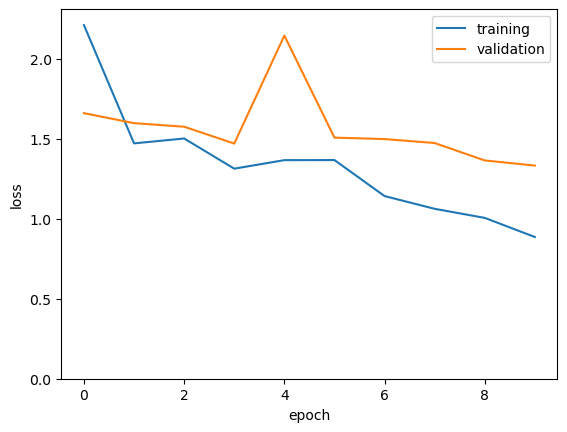

<Figure size 640x480 with 0 Axes>

In [16]:
transformer = Transformer(len(vocab_en), len(vocab_fr),3,3, 512, 8,  512, 0.1).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, train_dataloader, val_dataloader,  criterion, optimizer,"")

In [10]:
def translate(model, src):
    src=text_en(src)
    src=src.reshape(len(src),1).to(DEVICE)
    trg=[BOS_IDX]
    memory = model.encode(src)
    for i in range(len(src)+10):
        out=model.decode(torch.tensor(trg).reshape(len(trg),1).to(DEVICE), memory)
        prob=model.generator(out[i])
        next_word=torch.argmax(prob)
        trg+=[next_word]
        if next_word==EOS_IDX:
            break
    trg=vocab_fr.lookup_tokens(trg)
    return trg[1:(len(trg)-1)]

def evaluate(model, test_src, test_trg, samp_size, max_n, verbose=False):
    samp_size = np.min((samp_size,len(test_src)))
    score=np.empty(samp_size)
    samp=np.random.choice(len(test_src), samp_size, replace=False)
    for i in range(samp_size):
        idx=samp[i]
        pred=translate(model,test_src[idx])
        if (verbose):
            print(test_trg[idx])
            print(" ".join(pred))
        score[i]=bleu_score([pred], [[spacy_fr(test_trg[idx])]],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)


In [20]:
print(" ".join(translate(transformer,"I am.")))
print(" ".join(translate(transformer,"You are.")))
print(" ".join(translate(transformer,"He is.")))
print(" ".join(translate(transformer,"She is.")))
print(" ".join(translate(transformer,"We are.")))
print(" ".join(translate(transformer,"They are.")))

Je suis .
Vous êtes .
Il est .
Elle est .
Nous sommes cousines .
Elles sont disputées .


In [22]:
#downloaded from https://huggingface.co/datasets/Nicolas-BZRD/Parallel_Global_Voices_English_French
dat1=pd.read_parquet("eng_-french2.parquet")

In [23]:
dat1_en=dat1["en"].to_numpy()[0:10000]
dat1_fr=dat1["fr"].to_numpy()[0:10000]

In [24]:
print(evaluate(transformer, dat_en, dat_fr, 1000, 4))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 4))

(0.34987242880870906, 0.40200241758670113)
(0.010633491030952517, 0.05669263078028681)


In [ ]:
def tune_layers(n_encoders,n_decoders):
    transformer = Transformer(len(vocab_en), len(vocab_fr),n_encoders,n_decoders, 512, 8,  512, 0.1).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = torch.optim.Adam(transformer.parameters())
    train(transformer, train_dataloader,val_dataloader,
          criterion, optimizer, "{} encoders, {} decoders".format(n_encoders,n_decoders))
    print(evaluate(transformer, dat_en, dat_fr, 1000, 4))
    print(evaluate(transformer, dat1_en, dat1_fr, 1000, 4))
    return transformer

In [ ]:
transformer=tune_layers(4,4)

In [ ]:
def evaluate(model, test_src, test_trg, samp_size, max_n, verbose=False):
    samp_size = np.min((samp_size,len(test_src)))
    score=np.empty(samp_size)
    samp=np.random.choice(len(test_src), samp_size, replace=False)
    for i in range(samp_size):
        idx=samp[i]
        pred=translate(model,test_src[idx])
        if (verbose):
            print(test_trg[idx])
            print(" ".join(pred))
        score[i]=bleu_score([pred], [spacy_fr(test_trg[idx])],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)


In [ ]:
def evaluate_baseline(pred, test_trg, max_n, verbose=False):
    samp_size = len(pred)
    for i in range(samp_size):
        score[i]=bleu_score([pred[i]], [spacy_fr(test_trg[i])],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)
